In [1]:
import sys
!{sys.executable} -m pip install PyPortfolioOpt

  Using cached PyPortfolioOpt-1.2.6-py3-none-any.whl (48 kB)
  Using cached cvxopt-1.2.5.post1-cp38-cp38-win_amd64.whl (9.5 MB)
  Using cached cvxpy-1.1.6.tar.gz (1.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached osqp-0.6.1-cp38-none-win_amd64.whl (153 kB)
  Using cached ecos-2.0.7.post1.tar.gz (126 kB)
  Using cached scs-2.1.2.tar.gz (3.5 MB)
  Created wheel for cvxpy: filename=cvxpy-1.1.6-cp38-cp38-win_amd64.whl size=815122 sha256=845883cbe0c35a93c93b1dbf11cd9f8beceb3bab6517fc25774bb90cde0e4dfb
  Stored in directory: c:\users\pokem\appdata\local\pip\cache\wheels\ae\53\5c\a49c09293f6d50ceb68364c8fe088bede2cb5a396f0b17d9ab
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp38-cp38-win_amd64.whl size=684

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.optimize as solver
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [4]:
Data_FF = pd.read_excel('Data_Project_2_2020.xlsx',header=None)
Data_FF.columns = ['Date','mktrf','smb','hml','RMW','CMA','rf','umd']# Specify the names of the columns
Data_FF = Data_FF.drop(0,axis=0) #drop first row
Data_FF.set_index('Date',inplace=True)
Data_FF = Data_FF.astype(float) / 100

#load the data for mutual fund, hedge fund and smart beta
xls = pd.ExcelFile('Data_Project_2_2020.xlsx')
MF = pd.read_excel(xls, 'Mutual Fund')
SB = pd.read_excel(xls, 'Smart Beta')
HF = pd.read_excel(xls, 'Hedge Fund Index')
for i in [MF,SB,HF]:
    i.set_index('Date',inplace=True)
    
#organize the index of all matrices
for i in [Data_FF,MF,SB,HF]:
    i.index = i.index.astype(str)

### **3.1 Mutual Fund**

In [5]:
#subtract risk free rate from mutual fund returns
for i in MF.columns:
    MF[i] = MF[i]-Data_FF['rf']['200001':'201912']
MF

,FSMEX,FSELX,INPIX,SLMCX,CSEIX,FSPHX,NASDX,JAENX,JENSX,DAPAX
Date,,,,,,,,,,
200001,0.056113,0.034941,NaN,-0.033730,0.008082,0.057749,NaN,0.020682,-0.033634,0.002754
200002,0.053932,0.312105,NaN,0.169528,-0.029464,-0.017579,NaN,0.234341,0.023280,0.021133
200003,0.007528,0.034289,NaN,0.012394,0.002034,-0.018846,NaN,-0.125744,0.096642,0.062415
200004,-0.082452,-0.080524,NaN,-0.034377,0.084941,0.010679,NaN,-0.131207,-0.093561,-0.024906
200005,0.153262,-0.067974,NaN,-0.108182,0.014813,0.059801,-0.118706,-0.094011,0.138287,-0.031500
...,...,...,...,...,...,...,...,...,...,...
201908,-0.013437,-0.038220,-0.095215,-0.030842,0.047591,-0.028800,-0.022455,-0.018193,-0.012694,-0.012344
201909,-0.016282,0.043034,-0.033417,0.019207,0.002948,-0.026060,0.004057,0.008382,0.010205,-0.004127
201910,0.019545,0.062866,-0.014216,0.044437,0.021359,0.065504,0.043998,-0.003588,0.015058,0.024939


In [6]:
#extract and name the sample period for mutual funds benchmark 
MF_FF = Data_FF.loc['200001':'201912']

#append the mutual fund data with the benchmark data to facilitate regression
MF_reg = pd.concat([MF,MF_FF],axis=1)

In [7]:
#create a dataframe to contain mutual fund regression data
MF_data = pd.DataFrame(index=MF.columns,columns=['alpha','mktrf', 'smb', 'hml', 'RMW', 'CMA', 'umd'])

##create a dataframe to contain t-statistics for the regression data
MF_tstat=pd.DataFrame(index=MF.columns,columns=['alpha','mktrf', 'smb', 'hml', 'RMW', 'CMA', 'umd'])

#regress the 10 mutual funds return 
for i in MF.columns:
    reg_MF = smf.ols(i+'~mktrf+smb+hml+RMW+CMA+umd', data=MF_reg).fit()
    MF_data.loc[i]=reg_MF.params.tolist()
    MF_tstat.loc[i]=reg_MF.tvalues.tolist()

In [8]:
#define functions to highlight funds with significant alphas 
def significant_tstat(company):
    if company.alpha > 2:
        return ['background-color: yellow']*7
    else:
        return ['background-color: white']*7

In [9]:
MF_data

,alpha,mktrf,smb,hml,RMW,CMA,umd
FSMEX,0.00757705,0.638099,0.214359,-0.12127,0.0247859,0.0391784,0.0576483
FSELX,0.0060963,1.2897,0.402892,-0.578621,-0.578405,-0.272267,-0.31282
INPIX,0.00930979,1.79539,0.0923473,-0.9673,-1.60942,-0.527543,-0.133
SLMCX,0.00519459,1.10094,0.174928,-0.428814,-0.326718,-0.403642,-0.121933
CSEIX,0.00326651,0.772901,0.382543,0.331016,0.325209,0.0728138,-0.153398
FSPHX,0.0872446,-1.25834,0.531754,4.07658,-1.75181,-3.74356,-0.335507
NASDX,0.00289626,1.1417,-0.0350247,-0.542842,-0.392128,-0.236024,-0.0978886
JAENX,0.00161439,0.97125,0.369851,-0.285126,-0.347307,-0.317293,0.0424909
JENSX,0.000636456,0.87975,-0.0820213,-0.0525534,0.245195,0.201311,-0.0280035
DAPAX,0.000105237,0.973914,-0.0483844,-0.267764,0.0570485,-0.175384,-0.0570613


In [10]:
MF_tstat.style.apply(significant_tstat, axis=1)

,alpha,mktrf,smb,hml,RMW,CMA,umd
FSMEX,2.620136,8.062870,1.971471,-0.929382,0.183223,0.216225,0.986623
FSELX,1.765433,13.647456,3.103108,-3.713601,-3.580692,-1.258392,-4.483527
INPIX,2.487758,17.062459,0.608376,-5.720817,-8.389955,-2.220587,-1.656127
SLMCX,1.897756,14.697052,1.699698,-3.471958,-2.551601,-2.353539,-2.204716
CSEIX,0.847061,7.323743,2.638369,1.902377,1.802788,0.301356,-1.968752
FSPHX,1.598255,-0.842331,0.259085,1.655081,-0.686035,-1.094531,-0.304194
NASDX,1.891440,26.426826,-0.575390,-7.856634,-5.033826,-2.418496,-3.095918
JAENX,1.014798,22.308998,6.183325,-3.972132,-4.666978,-3.183224,1.321930
JENSX,0.376223,19.002622,-1.289516,-0.688483,3.098412,1.899241,-0.819276
DAPAX,0.053155,17.975399,-0.649993,-2.997420,0.615992,-1.413855,-1.426469


## **Part 2**

In [11]:
MF

,FSMEX,FSELX,INPIX,SLMCX,CSEIX,FSPHX,NASDX,JAENX,JENSX,DAPAX
Date,,,,,,,,,,
200001,0.056113,0.034941,NaN,-0.033730,0.008082,0.057749,NaN,0.020682,-0.033634,0.002754
200002,0.053932,0.312105,NaN,0.169528,-0.029464,-0.017579,NaN,0.234341,0.023280,0.021133
200003,0.007528,0.034289,NaN,0.012394,0.002034,-0.018846,NaN,-0.125744,0.096642,0.062415
200004,-0.082452,-0.080524,NaN,-0.034377,0.084941,0.010679,NaN,-0.131207,-0.093561,-0.024906
200005,0.153262,-0.067974,NaN,-0.108182,0.014813,0.059801,-0.118706,-0.094011,0.138287,-0.031500
...,...,...,...,...,...,...,...,...,...,...
201908,-0.013437,-0.038220,-0.095215,-0.030842,0.047591,-0.028800,-0.022455,-0.018193,-0.012694,-0.012344
201909,-0.016282,0.043034,-0.033417,0.019207,0.002948,-0.026060,0.004057,0.008382,0.010205,-0.004127
201910,0.019545,0.062866,-0.014216,0.044437,0.021359,0.065504,0.043998,-0.003588,0.015058,0.024939


In [12]:
#define the in-sample and out-of-sample dataset
insample_MF = MF['200001':'201212']
outsample_MF = MF['201301':'201912']

insample_HF = HF['200001':'201212']
outsample_HF = HF['201301':'201912']

insample_SB = SB['200001':'201212']
outsample_SB = SB['201301':'201912']

### **Mutual Fund Portfolios**

#### Global-Minimum Variance Portfolio

In [13]:
outsample_MF

,FSMEX,FSELX,INPIX,SLMCX,CSEIX,FSPHX,NASDX,JAENX,JENSX,DAPAX
Date,,,,,,,,,,
201301,0.125182,0.063550,0.232434,0.117341,0.043766,0.147765,0.029360,0.091914,0.064802,0.037635
201302,-0.001306,0.029551,0.005076,-0.005330,0.012876,0.010016,0.005722,0.009770,0.014888,0.011658
201303,0.037582,0.027700,0.016835,0.018639,0.027542,0.065118,0.028450,0.026892,0.027465,0.014084
201304,-0.020158,-0.019531,0.005795,-0.011436,0.066467,0.012957,0.026887,-0.001108,0.017841,0.044251
201305,0.055862,0.078529,0.085597,0.041879,-0.056958,0.059148,0.033738,0.029546,0.016756,0.019778
...,...,...,...,...,...,...,...,...,...,...
201908,-0.013437,-0.038220,-0.095215,-0.030842,0.047591,-0.028800,-0.022455,-0.018193,-0.012694,-0.012344
201909,-0.016282,0.043034,-0.033417,0.019207,0.002948,-0.026060,0.004057,0.008382,0.010205,-0.004127
201910,0.019545,0.062866,-0.014216,0.044437,0.021359,0.065504,0.043998,-0.003588,0.015058,0.024939


In [14]:
covariance_MFIS = insample_MF.cov()
covariance_MFOS=outsample_MF.cov()

In [15]:
#define the objective functions for the insample and outsample optimization problems
def port_std_MFIS(w):
    return np.sqrt(reduce(np.dot, [w, covariance_MFIS, w.T]))  
def port_std_MFOS(w):
    return np.sqrt(reduce(np.dot, [w, covariance_MFOS, w.T]))  

In [16]:
#define the optimization function given the objective function and number of assets
def GMVoptimize(func, num):
    init = np.array([1.0 / num for x in range(num)])  
    bounds = tuple((0, 1) for x in range(num))  
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}]
    outcome = solver.minimize(func, x0=init, constraints=constraints, bounds=bounds)  
    return outcome.x

In [17]:
#calculate the global minimum variance portfolio for mutual funds
def GMV_port(op_weights,returns):
    GMV_mean = sum(op_weights*returns.mean())
    GMV_std = np.sqrt(reduce(np.dot, [op_weights, returns.cov(), op_weights.T]))  
    return [GMV_mean,GMV_std]

In [18]:
#generate random weights in order to generate random portfolios
def weights(k):
    w = np.random.rand(k)
    return w/sum(w)

#given the asset returns, graph the mean and variance for a set number of random portfolios
def portfolios(returns,simulations):
    means=returns.mean()
    cov_matrix=returns.cov()
    port_return = []
    port_std = []
    for _ in range(simulations):
        w = weights(10)
        port_return.append(sum(means * w))
        port_std.append(np.sqrt(reduce(np.dot, [w, cov_matrix, w.T])))
    plt.plot(port_std, port_return,'bo')

In [19]:
#calculate the optimal portfolio weights using the in-sample data
insample_weights = GMVoptimize(port_std_MFIS,10)
insample_weights

array([2.32594184e-01, 0.00000000e+00, 1.82145965e-17, 9.75781955e-19,
       3.46944695e-18, 2.04213806e-01, 0.00000000e+00, 0.00000000e+00,
       5.59002930e-01, 4.18908040e-03])

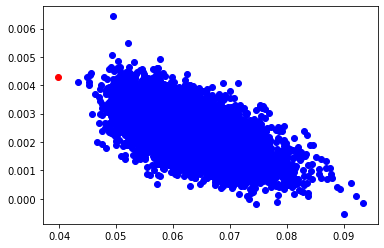

In [20]:
portfolios(insample_MF,10000)
plt.plot(GMV_port(insample_weights,insample_MF)[1],
         GMV_port(insample_weights,insample_MF)[0],'ro')

In [21]:
def GMVoptimize_extend(func, num):
    init = np.array([1.0 / num for x in range(num)])  
    bounds = tuple((-1, 1) for x in range(num))  
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}]
    outcome = solver.minimize(func, x0=init, constraints=constraints, bounds=bounds)  
    return outcome.x

In [22]:
insample_weights_extend = GMVoptimize_extend(port_std_MFIS,10)
insample_weights_extend

array([ 0.26681885, -0.22840148, -0.34684613,  0.23861974, -0.02068274,
       -0.00936693,  0.57419256,  0.01841887,  0.35030331,  0.15694395])

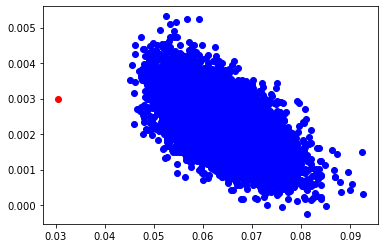

In [23]:
portfolios(insample_MF,10000)
plt.plot(GMV_port(insample_weights_extend,insample_MF)[1],
         GMV_port(insample_weights_extend,insample_MF)[0],'ro')

In [24]:
#Create table for output 
Port_op_MF = pd.DataFrame(index=['Long only GMV','Long only MVP','Long short GMV',
                                'Long short MVP','Tracking error <5%','Factor Neutral'], columns = ['Mean',
                                                                                                   'volatility','sharpe','mktrf','smb','hml',
                                                                                                   'RMW','CMA','umd'])

In [25]:
insample_rf=Data_FF.loc['200001':'201212']['rf'].mean()

Port_op_MF.loc['Long only GMV']['Mean']= GMV_port(insample_weights,insample_MF)[0]
Port_op_MF.loc['Long only GMV']['volatility']= GMV_port(insample_weights,insample_MF)[1] ** 2
Port_op_MF.loc['Long only GMV']['sharpe']=(Port_op_MF.loc['Long only GMV']['Mean'])/(Port_op_MF.loc['Long only GMV']['volatility']**0.5)
for i in ['mktrf','smb','hml', 'RMW','CMA','umd']:
    Port_op_MF.loc['Long only GMV'][i]=MF_data[i].dot(insample_weights)
    
Port_op_MF.loc['Long short GMV']['Mean']= GMV_port(insample_weights_extend,insample_MF)[0]
Port_op_MF.loc['Long short GMV']['volatility']= GMV_port(insample_weights_extend,insample_MF)[1] ** 2
Port_op_MF.loc['Long short GMV']['sharpe']=(Port_op_MF.loc['Long short GMV']['Mean'])/(Port_op_MF.loc['Long short GMV']['volatility']**0.5)
for i in ['mktrf','smb','hml', 'RMW','CMA','umd']:
    Port_op_MF.loc['Long short GMV'][i]=MF_data[i].dot(insample_weights_extend)

In [65]:
def sharpe(w):
    return -(np.dot(w,insample_MF.mean()))/ (np.sqrt(reduce(np.dot, [w, covariance_MFIS, w.T])))

In [68]:
def testoptimize_extend(func, num):
    init = np.array([1.0 / num for x in range(num)])  
    bounds = tuple((-1, 1) for x in range(num))  
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}]
    outcome = solver.minimize(func, x0=init, constraints=constraints, bounds=bounds)  
    return outcome.x

In [69]:
testoptimize_extend(sharpe,10)

array([ 1.        , -0.02928817, -0.28326399,  0.72164475,  0.5131264 ,
       -0.06459311,  0.38762059, -0.53504572,  0.28979925, -1.        ])

In [ ]:
def portfolio(weights): #we want a summary of the best portfolio. This function takes given weights and gives return, volatility, Sharpe 
    weights=np.array(weights) 
    P_ret=np.sum(returns.mean()*weights)*252 
    P_vol=np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    return np.array([P_ret,P_vol, P_ret/P_vol])

bnds=tuple((0,1) for x in range(no_assets)) #each asset will be constraint between 0 and 1, repeating (0,1) for as many assets as we have


def Sharpe(weights): #we want to find the maximum Sharpe ratio
    return -portfolio(weights)[2] #function returns the negative of the Sharpe ratio (to max Sharpe, minimize -Sharpe), [2] is the 3rd element from our portfolio function above (3rd element = Sharpe)

cons=({'type':'eq', 'fun':lambda x: np.sum(x)-1}) #constraint is a dictionary, the type is an equality, the function of the cons makes sure the sum of the weights is 1
bnds=tuple((0,1) for x in range(no_assets)) #lambda tells which function to focus on 

opt_S=sco.minimize(Sharpe, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons) # starting value is our equally weighted portfolio i.e number of assets * 1/NoOfA

print (opt_S['x'].round(3)) # what are the weights rounded to 3 decimal places. x here is a string, look at opt_S below where x is, we want only x, opt_S has many things such as our negative Sharpe etc. x has the weights

portfolio(opt_S['x']) # statistics, expected returns increases, variance increases, our Sharpe increased. weights are 66%, 9%, 25%...


def Variance(weights):
    return portfolio(weights)[1]**2 #variance is stdev (volatility) squared where volatility is our second element [1]

opt_V=sco.minimize(Variance, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons) #bonds and cons already done above

print (opt_V['x'].round(3)) # weights
portfolio(opt_V['x']) # statistics


for i in HF.columns:
    HF[i] = HF[i]-Data_FF['rf']['199001':'201912']

In [ ]:
def Variance(weights):
    return portfolio(weights)[1]**2 #variance is stdev (volatility) squared where volatility is our second element [1]

opt_V=sco.minimize(Variance, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons) #bonds and cons already done above

print (opt_V['x'].round(3)) # weights
portfolio(opt_V['x']) # statistics

16:14
for i in HF.columns:
    HF[i] = HF[i]-Data_FF['rf']['199001':'201912']

16:14
#extract and name the sample period for hedge funds benchmark 
HF_FF = Data_FF.loc['199001':'201912']

#append the hedge fund data with the benchmark data to facilitate regression
HF_reg = pd.concat([HF,HF_FF],axis=1)

16:14
HF_data = pd.DataFrame(index=HF.columns,columns=['alpha','mktrf', 'smb', 'hml', 'RMW', 'CMA', 'umd'])

##create a dataframe to contain t-statistics for the regression data
HF_tstat=pd.DataFrame(index=HF.columns,columns=['alpha','mktrf', 'smb', 'hml', 'RMW', 'CMA', 'umd'])

#regress the 10 hedge funds return 
for i in HF.columns:
    reg_HF = smf.ols(i+'~mktrf+smb+hml+RMW+CMA+umd', data=HF_reg).fit()
    HF_data.loc[i]=reg_HF.params.tolist()
    HF_tstat.loc[i]=reg_HF.tvalues.tolist()

16:14
HF_data

16:14
HF_tstat.style.apply(significant_tstat, axis=1)

In [61]:
mu=insample_MF.mean()
for i in range(0,10):
    if mu[i] <= 0:
        mu[i]=0
mu

FSMEX    0.007654
FSELX    0.001420
INPIX    0.000000
SLMCX    0.002003
CSEIX    0.009977
FSPHX    0.004101
NASDX    0.000000
JAENX    0.000000
JENSX    0.003021
DAPAX    0.000000
dtype: float64

In [62]:
COV=covariance_MFIS
COV

,FSMEX,FSELX,INPIX,SLMCX,CSEIX,FSPHX,NASDX,JAENX,JENSX,DAPAX
FSMEX,0.002110,0.002105,0.003219,0.001609,0.001719,0.001777,0.001590,0.001732,0.001322,0.001418
FSELX,0.002105,0.011584,0.013500,0.007602,0.002782,0.002112,0.007402,0.005904,0.002546,0.004493
INPIX,0.003219,0.013500,0.023768,0.010578,0.004255,0.003424,0.011190,0.008746,0.003906,0.006552
SLMCX,0.001609,0.007602,0.010578,0.006365,0.002017,0.001661,0.005542,0.004703,0.001888,0.003295
CSEIX,0.001719,0.002782,0.004255,0.002017,0.005516,0.001756,0.002262,0.002273,0.001558,0.002228
FSPHX,0.001777,0.002112,0.003424,0.001661,0.001756,0.002198,0.001854,0.001682,0.001252,0.001649
NASDX,0.001590,0.007402,0.011190,0.005542,0.002262,0.001854,0.006021,0.004612,0.002061,0.003529
JAENX,0.001732,0.005904,0.008746,0.004703,0.002273,0.001682,0.004612,0.004847,0.001719,0.002906
JENSX,0.001322,0.002546,0.003906,0.001888,0.001558,0.001252,0.002061,0.001719,0.001820,0.001623
DAPAX,0.001418,0.004493,0.006552,0.003295,0.002228,0.001649,0.003529,0.002906,0.001623,0.002973


In [63]:
ef=EfficientFrontier(mu,S)

In [64]:
ef.max_sharpe()

OptimizationError: Please check your objectives/constraints or use a different solver.

,FSMEX,FSELX,INPIX,SLMCX,CSEIX,FSPHX,NASDX,JAENX,JENSX,DAPAX
FSMEX,590235.015212,5704.796433,4582.343073,-4948.025935,-5305.608706,863.928393,227.882573,-1067.490367,-4296.583057,2229.352391
FSELX,5704.796433,10457.399880,906.493318,-3063.948858,1226.836375,-3859.454737,483.162001,-2764.016069,1184.842407,-7660.705561
INPIX,4582.343073,906.493318,160263.687497,-155.847139,-18.296409,-3162.903827,1074.705216,4097.743071,645.353747,64971.401973
SLMCX,-4948.025935,-3063.948858,-155.847139,4419.326077,217.189660,-494.694850,3253.317043,2332.392386,822.009183,131.177150
CSEIX,-5305.608706,1226.836375,-18.296409,217.189660,47769.848317,-6724.880984,-255.279522,-313.573738,-101.109387,7467.554585
FSPHX,863.928393,-3859.454737,-3162.903827,-494.694850,-6724.880984,46371.694382,-3827.422014,-830.660261,-1490.724306,2842.110401
NASDX,227.882573,483.162001,1074.705216,3253.317043,-255.279522,-3827.422014,86050.971068,1761.257537,-49.694977,971.735037
JAENX,-1067.490367,-2764.016069,4097.743071,2332.392386,-313.573738,-830.660261,1761.257537,4414.871724,-57.009386,13118.388392
JENSX,-4296.583057,1184.842407,645.353747,822.009183,-101.109387,-1490.724306,-49.694977,-57.009386,32872.632849,196.999023
DAPAX,2229.352391,-7660.705561,64971.401973,131.177150,7467.554585,2842.110401,971.735037,13118.388392,196.999023,951384.408183


In [53]:
import objective_functions

ef = EfficientFrontier(mu, S)
weights = ef.nonconvex_objective(
        objective_functions.sharpe_ratio,
        objective_args=(ef.expected_returns, ef.cov_matrix),
        weights_sum_to_one=True,
    )

ModuleNotFoundError: No module named 'objective_functions'